In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
amazonData = pd.read_csv('Amazon_Unlocked_Mobile.csv')
amazonData.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [3]:
amazonData = amazonData.dropna(axis=0)

In [4]:
amazonData.shape

(334335, 6)

In [5]:
amazonData = amazonData[["Reviews","Rating"]]

In [6]:
amazonDataPositiveDf = amazonData[amazonData["Rating"].isin([4,5])]
amazonDataNegativeDf = amazonData[amazonData["Rating"].isin([1,2])]
amazonDataNeutralDf = amazonData[amazonData["Rating"].isin([3])]

In [7]:
print('Positive: ', amazonDataPositiveDf.shape)
print('Neutal: ', amazonDataNeutralDf.shape)
print('Negative: ', amazonDataNegativeDf.shape)

Positive:  (230674, 2)
Neutal:  (26058, 2)
Negative:  (77603, 2)


In [8]:
amazonDataFiltered = pd.concat([amazonDataPositiveDf[:20000], amazonDataNeutralDf[:20000], amazonDataNegativeDf[:20000]])

<AxesSubplot:>

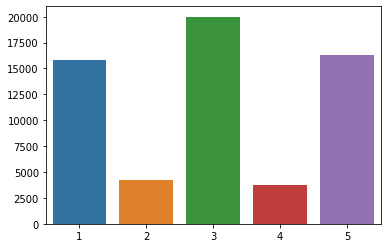

In [9]:
sns.barplot(x=amazonDataFiltered.Rating.value_counts().index, y=amazonDataFiltered.Rating.value_counts().values)

In [10]:
amazonDataFiltered["Sentiment"] = "Positive"
amazonDataFiltered["Sentiment"][amazonDataFiltered["Rating"].isin([1,2])]= "Negative"
amazonDataFiltered["Sentiment"][amazonDataFiltered["Rating"].isin([3])]= "Neutral"

C:\Users\Admin\AppData\Local\Temp/ipykernel_11288/3810887326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazonDataFiltered["Sentiment"][amazonDataFiltered["Rating"].isin([1,2])]= "Negative"
C:\Users\Admin\AppData\Local\Temp/ipykernel_11288/3810887326.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazonDataFiltered["Sentiment"][amazonDataFiltered["Rating"].isin([3])]= "Neutral"


In [11]:
amazonDataFiltered[20000:20005]

,Reviews,Rating,Sentiment
9,It's battery life is great. It's very responsi...,3,Neutral
10,"My fiance had this phone previously, but cause...",3,Neutral
19,unfortunately Sprint could not activate the ph...,3,Neutral
26,the reasons for the 3 star rating was it was i...,3,Neutral
44,"I love the phone, but one problem and one prob...",3,Neutral


In [12]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

def lower_case(text):
    return text.lower()
def remove_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
def remove_username(text):
    return re.sub('@[^\s]+','',text)
def remove_urls(text):
    return re.sub(r"((http\S+)|(www\.))",'',text)
def remove_special_characters(text):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern,'',text)
    return text
def remove_single_char(text):
    return re.sub(r'\b[a-zA-Z]\b','',text)
def remove_multiple(text):
    return re.sub("(.)\\1{2,}","\\1",text)
tokenizer = ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    tokens = [token.lower() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_tokens = ' '.join(filtered_tokens)
    return filtered_tokens

In [13]:
import json
with open('contractions.json','r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']
def replace_contractions(text):
    for word in text.split():
        if word.lower()  in contractions:
            text = text.replace(word,contractions[word.lower()])
    return text

In [21]:
with open('negations.json','r') as f:
    neg_dict = json.load(f)
negations = neg_dict['negations']

#Antonyms
#Negation Handler
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
# from nltk.
class AntonymReplacer(object):
    def replace(self,word):
        antonyms = set()
        for syn in wordnet.synsets(word):
            if syn.pos() in ['a' ,'s']:
                for lemma in syn.lemmas():
                    for antonym in lemma.antonyms():
                        antonyms.add(antonym.name())
        if(len(antonyms) == 1):
            return antonyms.pop()
        else:
            if word in negations:
                word = word.replace(word,negations[word])
                return word
        
    #Negation Replacer
    def negReplacer(self, string):
        i=0
        finalSent = ""
        sent = word_tokenize(string)
        length_sent = len(sent)
        words = []
        while i < length_sent:
            word = sent[i]
            if word == 'not' and i+1 < length_sent:
                antonymWord = self.replace(sent[i+1])
                if antonymWord:
                    words.append(antonymWord)
                    finalSent += antonymWord + " "
                    i += 2
                    continue
            words.append(word)
            finalSent += word + " "
            i += 1
        return finalSent
    
# replacer = AntonymReplacer()
# oppWord = replacer.negReplacer('not recommend')
# print(oppWord)
    
def replace_negation(text):
    
    replacer = AntonymReplacer()
    oppWord = replacer.negReplacer(text)
    return oppWord

# replace_negation('I am heavy')

In [15]:
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(lower_case)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(remove_multiple)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(remove_single_char)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(remove_special_characters)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(remove_square_brackets)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(remove_urls)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(remove_username)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(replace_contractions)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(replace_negation)
amazonDataFiltered['Reviews'] =amazonDataFiltered['Reviews'].apply(remove_stopwords)

In [16]:
from sklearn.model_selection import train_test_split
X = amazonDataFiltered["Reviews"]
y = amazonDataFiltered["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vector = TfidfVectorizer()
tfidf_vector.fit(X_train)
X_train_data = tfidf_vector.transform(X_train)
X_test_data = tfidf_vector.transform(X_test)

In [18]:
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train_data, y_train)
predictions = MNB.predict(X_test_data)

In [20]:
from sklearn.metrics import accuracy_score, classification_report
print('Train accuracy: ',accuracy_score(y_train, MNB.predict(X_train_data)))
print('Test accuracy:', accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Train accuracy:  0.8284375
Test accuracy: 0.8066666666666666
              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82      3901
     Neutral       0.75      0.75      0.75      4063
    Positive       0.86      0.84      0.85      4036

    accuracy                           0.81     12000
   macro avg       0.81      0.81      0.81     12000
weighted avg       0.81      0.81      0.81     12000



In [22]:
X_test

240996    phone since march really trying like convenien...
98090     know company phone bought exact item ment used...
174424                               looks good worth money
2629                                      luv luv luv phone
31079     apple iphone c blue go phone past year absolut...
                                ...                        
249572    true phone inexpensive needed store phone numb...
34792                          phone works good sent africa
21907     would say vendor banned purchased two iphone u...
255048    battery life sucks wonder got lemon otherwise ...
100394    phone comes repowered sold new saying scratche...
Name: Reviews, Length: 12000, dtype: object

In [23]:
list_of_tuples = list(zip(X_test, predictions))
pd.DataFrame(list_of_tuples, columns = ['Text', 'Sentiment'])

,Text,Sentiment
0,phone since march really trying like convenien...,Neutral
1,know company phone bought exact item ment used...,Negative
2,looks good worth money,Positive
3,luv luv luv phone,Positive
4,apple iphone c blue go phone past year absolut...,Positive
...,...,...
11995,true phone inexpensive needed store phone numb...,Neutral
11996,phone works good sent africa,Positive
11997,would say vendor banned purchased two iphone u...,Negative
11998,battery life sucks wonder got lemon otherwise ...,Neutral


In [24]:
print('Train acc: ',accuracy_score(y_train, MNB.predict(X_train_data)))
print('Test acc: ', accuracy_score(y_test, predictions))

Train acc:  0.8284375
Test acc:  0.8066666666666666


In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

# it shoes that out of 1012 data, 112 data that are acutally positive is predicted as negative

array([[3255,  522,  124],
       [ 581, 3053,  429],
       [ 184,  480, 3372]], dtype=int64)

In [36]:
text1 = [
#         'Will not repurchase. Do not recommend',
#        'I hate this',
#        'I love this',
#        'This is not worth it',
#        'This is not terrible',
#        'This product so far has not disappointed',
        'Excellent product. Easy to use, large screen makes watching movies and reading easier.',
        'I am so happy today',
       'Note 10 has great camera quality. I am loving it.',
       'I dont know what is wrong with this phone. I have been trying to type but its not working.',
       'Dell laptop battery dead',
        'Good, but unhappy that screen size is small, less than I expected',
       'The product has not disappointed',
       'It is a expensive phone',
       'I hate apple',
        'less expensive than last year with so many more features and bigger screen!',
        'I do not enjoy working under tight deadline',
        'worst phone in the history',
        'phone is not good but has nice screen'
]
# print(text1)
text_df1 = pd.DataFrame(text1,columns=['text'])
# print(text_df1)


In [37]:
text_df1['text'] =text_df1['text'].apply(lower_case)
text_df1['text'] =text_df1['text'].apply(remove_multiple)
text_df1['text'] =text_df1['text'].apply(remove_single_char)
text_df1['text'] =text_df1['text'].apply(remove_special_characters)
# text_df1['text'] =text_df1['text'].apply(remove_stopwords)
text_df1['text'] =text_df1['text'].apply(remove_square_brackets)
text_df1['text'] =text_df1['text'].apply(remove_urls)
text_df1['text'] =text_df1['text'].apply(remove_username)
text_df1['text'] =text_df1['text'].apply(replace_contractions)
text_df1['text'] =text_df1['text'].apply(replace_negation)
# text_df1['text'] =text_df1['text'].apply(remove_stopwords)

In [38]:
text=tfidf_vector.transform(text_df1['text'])

In [39]:
prediction = MNB.predict(text)

In [40]:
X_test

105420    stopped working months would reboot menu scree...
10121     bought phone th december shouldve received th ...
23450     give four stars think box previously opened cl...
1484      loved phone month last night turned turn back ...
37477     works great able take veroson activated daught...
                                ...                        
71689     star pay got toy phone gift scam cubed thats s...
34563                                         working great
64044     phone came locked previous itunes account hold...
164984    phone works price low found phone upgraded win...
289167                  excellent seller charger get broken
Name: Reviews, Length: 12000, dtype: object

In [41]:
list_of_tuples = list(zip(text_df1['text'], prediction))
pd.DataFrame(list_of_tuples, columns = ['Text', 'Sentiment'])

,Text,Sentiment
0,excellent product easy to use large screen mak...,Positive
1,am so happy today,Positive
2,note has great camera quality am loving it,Positive
3,dont know what is wrong with this phone have b...,Negative
4,dell laptop battery dead,Neutral
5,good but unhappy that screen size is small les...,Neutral
6,the product has satisfied,Positive
7,it is expensive phone,Neutral
8,hate apple,Negative
9,less expensive than last year with so many mor...,Neutral
